# Laboratory 2: Computer Vision

## SETUP

In [6]:
import comet_ml
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())
COMET_API_KEY = os.getenv("COMET_API_KEY")

In [8]:
import tensorflow as tf
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import mitdeeplearning as mdl

In [10]:
assert COMET_API_KEY != "", "Please insert your Comet API Key"

## 2.1 Datasets

In [11]:
# load data
path_to_training_data = tf.keras.utils.get_file(
    "train_face.h5", "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
)

loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step
Opening /Users/vamsi_mbmax/.keras/datasets/train_face.h5
Loading data into memory...


In [12]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

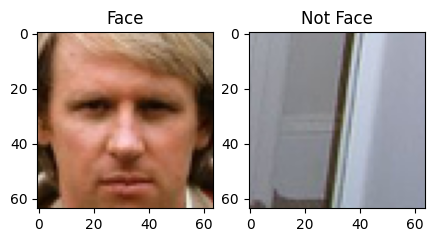

In [14]:
# examine the dataset
face_images = images[np.where(labels == 1)[0]]
not_face_images = images[np.where(labels == 0)[0]]

idx_face = 23  # @param {type:"slider", min:0, max:50, step:1}
idx_not_face = 9  # @param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)

## 2.2